# Data preprocessing

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import cv2
from tensorflow.keras.layers import Input, Lambda, MaxPooling2D, BatchNormalization, Dense, Flatten, Activation,Convolution2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
import os
from tensorflow.keras.losses import Loss
import keras

import os
import matplotlib
import matplotlib.image as mpimg
import matplotlib.cm as cm
from scipy import ndimage
from skimage.measure import regionprops
from skimage import io
from skimage.filters import threshold_otsu
from time import time


In [3]:
def read_data(dir, data):
    images1 = []
    images2 = []
    labels = []
    for j in range(0, len(data)):
        path = os.path.join(dir,data.iat[j, 0])
        img1 = cv2.imread(path)
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        img1 = cv2.resize(img1, (100, 100))
        images1.append([img1])
        path = os.path.join(dir, data.iat[j, 1])
        img2 = cv2.imread(path)
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
        img2 = cv2.resize(img2, (100, 100))
        images2.append([img2])
        labels.append(np.array(data.iat[j, 2]))
    images1 = np.array(images1).astype(np.float32) / 255.0
    images2 = np.array(images2).astype(np.float32) / 255.0
    labels = np.array(labels).astype(np.float32)
    return images1, images2, labels

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
train_dir = '/content/drive/MyDrive/signature-verification-dataset/sign_data/train'
train_csv = '/content/drive/MyDrive/signature-verification-dataset/sign_data/train_data.csv'
df_train = pd.read_csv(train_csv, header=None)
train_images1, train_images2, train_labels = read_data(dir=train_dir, data=df_train)
train_labels = to_categorical(train_labels)

In [6]:
test_dir = '/content/drive/MyDrive/signature-verification-dataset/sign_data/test'
test_csv = '/content/drive/MyDrive/signature-verification-dataset/sign_data/test_data.csv'
df_test = pd.read_csv(test_csv, header=None)
test_images1, test_images2, test_labels = read_data(dir=test_dir, data=df_test)
test_labels = to_categorical(test_labels)

In [7]:
# import tensorflow as tf
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# import matplotlib.pyplot as plt

# datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# genuine_image_path = "/content/drive/MyDrive/signature-verification-dataset/sign_data/train/001/001_01.PNG"
# forged_image_path = "/content/drive/MyDrive/signature-verification-dataset/sign_data/train/001_forg/0119001_01.png"

# img = tf.keras.preprocessing.image.load_img(genuine_image_path)
# img_array = tf.keras.preprocessing.image.img_to_array(img)
# img_array = tf.expand_dims(img_array, 0)

# augmented_images = datagen.flow(img_array)
# img_array_augmented = augmented_images.next()[0]
# plt.figure(figsize=(10, 10))

# # Original genuine image
# plt.subplot(1, 2, 1)
# plt.imshow(img_array[0].numpy().astype("uint8"))
# plt.title("Original Genuine Image")

# # Augmented genuine image
# plt.subplot(1, 2, 2)
# plt.imshow(img_array_augmented.astype("uint8"))
# plt.title("Augmented Genuine Image")

# # Show the plot for genuine image
# plt.show()


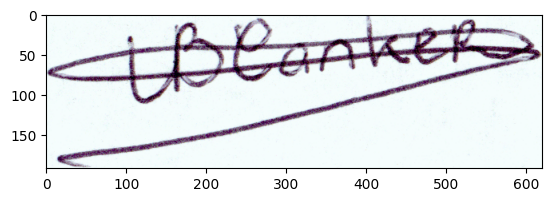

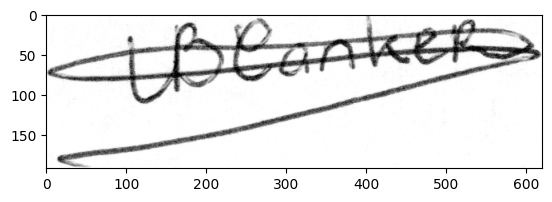

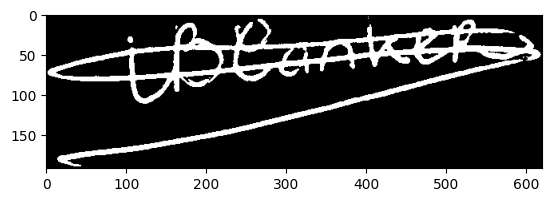

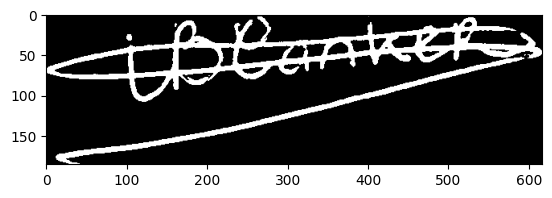

/content/drive/MyDrive/signature-verification-dataset/sign_data/train/003_forg/0121003_03.png


In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def rgbgrey(img):
    # Converts rgb to grayscale
    greyimg = np.zeros((img.shape[0], img.shape[1]))
    for row in range(len(img)):
        for col in range(len(img[row])):
            greyimg[row][col] = np.average(img[row][col])
    return greyimg

def greybin(img):
    # Converts grayscale to binary
    blur_radius = 0.8
    img = ndimage.gaussian_filter(img, blur_radius)  # to remove small components or noise
    thres = threshold_otsu(img)
    binimg = img > thres
    binimg = np.logical_not(binimg)
    return binimg

import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import random


def preproc(path, img=None, display=True):
    if img is None:
        img = mpimg.imread(path)
    if display:
        plt.imshow(img, cmap='gray')
        plt.show()

    grey = rgbgrey(img)
    if display:
        plt.imshow(grey, cmap='gray')
        plt.show()

    binimg = greybin(grey)
    if display:
        plt.imshow(binimg, cmap='gray')
        plt.show()

    r, c = np.where(binimg == 1)
    signimg = binimg[r.min(): r.max(), c.min(): c.max()]
    if display:
        plt.imshow(signimg, cmap='gray')
        plt.show()

    return signimg

def process_images_in_directory(directory_path, num_images=2):
    image_files = [f for f in os.listdir(directory_path) if f.endswith(".jpg") or f.endswith(".png")]
    random_sample = random.sample(image_files, min(num_images, len(image_files)))

    for filename in random_sample:
        image_path = os.path.join(directory_path, filename)
        preproc(image_path)
        print(image_path)
genuine_image_paths =  "/content/drive/MyDrive/signature-verification-dataset/sign_data/train/003"
forged_image_paths = "/content/drive/MyDrive/signature-verification-dataset/sign_data/train/003_forg"

process_images_in_directory(genuine_image_paths, num_images=1)
process_images_in_directory(forged_image_paths, num_images=1)


In [9]:
size = 100
train_images1 = train_images1.reshape(-1, size, size, 1)
train_images2 = train_images2.reshape(-1, size, size, 1)

In [10]:
print(df_train.iloc[0, :])
img_org = df_train.iloc[0, 0]
img_frg = df_train.iloc[0, 1]

0             068/09_068.png
1    068_forg/03_0113068.PNG
2                          1
Name: 0, dtype: object


/content/drive/MyDrive/signature-verification-dataset/sign_data/train/012/012_01.PNG


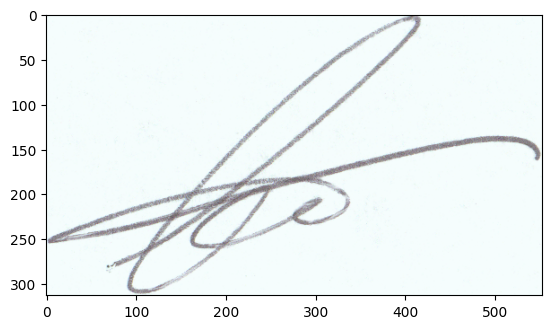

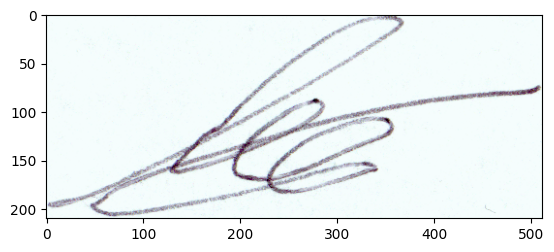

In [11]:
img_original_path = '/content/drive/MyDrive/signature-verification-dataset/sign_data/train/012/012_01.PNG'
img_forged_path = '/content/drive/MyDrive/signature-verification-dataset/sign_data/train/012_forg/0113012_01.png'

img_original = plt.imread(img_original_path)
img_forged = plt.imread(img_forged_path)

print(img_original_path)

plt.subplots(1, 1, sharex=True, sharey=True)
plt.imshow(img_original)

plt.subplots(1, 1, sharex=True, sharey=True)
plt.imshow(img_forged)

In [12]:
import os
import matplotlib.pyplot as plt
from skimage import color, io
import numpy as np
from skimage.measure import regionprops
import random

def preproc(path, display=False):
    img = io.imread(path)
    # Convert to grayscale
    grey = color.rgb2gray(img)
    # Apply thresholding
    binary_img = (grey > 0.5).astype(np.uint8)  # Adjust the threshold as needed

    if display:
        plt.imshow(binary_img, cmap='gray')
        plt.savefig('binary_image.png')  # Save the plot as an image file
        plt.close()

    return binary_img

def Ratio(img):
    a = np.sum(img)  # Count the number of white pixels
    total = img.shape[0] * img.shape[1]
    return a / total


def Centroid(img):
    numOfWhites = np.sum(img)
    row, col = np.indices(img.shape)
    row_centroid = np.sum(row * img) / numOfWhites
    col_centroid = np.sum(col * img) / numOfWhites
    return row_centroid / img.shape[0], col_centroid / img.shape[1]


def EccentricitySolidity(img):
    r = regionprops(img.astype("int8"))
    return r[0].eccentricity, r[0].solidity


def SkewKurtosis(img):
    h, w = img.shape
    x = np.arange(w)  # cols value
    y = np.arange(h)  # rows value

    # calculate projections along the x and y axes
    xp = np.sum(img, axis=0)
    yp = np.sum(img, axis=1)

    # centroid
    cx = np.sum(x * xp) / np.sum(xp)
    cy = np.sum(y * yp) / np.sum(yp)

    # standard deviation
    x2 = (x - cx) ** 2
    y2 = (y - cy) ** 2
    sx = np.sqrt(np.sum(x2 * xp) / np.sum(img))
    sy = np.sqrt(np.sum(y2 * yp) / np.sum(img))

    # skewness
    x3 = (x - cx) ** 3
    y3 = (y - cy) ** 3
    skewx = np.sum(xp * x3) / (np.sum(img) * sx ** 3)
    skewy = np.sum(yp * y3) / (np.sum(img) * sy ** 3)

    # Kurtosis
    x4 = (x - cx) ** 4
    y4 = (y - cy) ** 4
    # 3 is subtracted to calculate relative to the normal distribution
    kurtx = np.sum(xp * x4) / (np.sum(img) * sx ** 4) - 3
    kurty = np.sum(yp * y4) / (np.sum(img) * sy ** 4) - 3

    return (skewx, skewy), (kurtx, kurty)


def getFeatures(path, img=None, display=False):
    if img is None:
        img = io.imread(path)
    img = preproc(path, display=display)
    ratio = round(Ratio(img), 3)
    centroid = tuple(map(lambda x: round(x, 3), Centroid(img)))
    eccentricity = round(EccentricitySolidity(img)[0], 3)
    solidity = round(EccentricitySolidity(img)[1], 3)
    skewness = tuple(map(lambda x: round(x, 3), SkewKurtosis(img)[0]))
    kurtosis = tuple(map(lambda x: round(x, 3), SkewKurtosis(img)[1]))
    retVal = (ratio, centroid, eccentricity, solidity, skewness, kurtosis)
    return retVal


def getCSVFeatures(path, img=None, display=False):
    if img is None:
        img = preproc(path, display=display)
    temp = getFeatures(path, display=display)
    features = (temp[0], temp[1][0], temp[1][1], temp[2], temp[3], temp[4][0], temp[4][1], temp[5][0], temp[5][1])
    return features


def process_images_in_directory(directory_path, num_images=1):
    image_files = [f for f in os.listdir(directory_path) if f.endswith(".jpg") or f.endswith(".png")]
    random_sample = random.sample(image_files, min(num_images, len(image_files)))

    for filename in random_sample:
        image_path = os.path.join(directory_path, filename)
        img = io.imread(image_path)

        # Apply getFeatures and getCSVFeatures functions
        features = getFeatures(image_path, display=True)
        csv_features = getCSVFeatures(image_path, display=False)

        print(f"Features for {filename}: {features}")
        print(f"CSV Features for {filename}: {csv_features}")

# # Example directory path
image_paths = "/content/drive/MyDrive/signature-verification-dataset/sign_data/train/018"

# Process images in the directory
process_images_in_directory(image_paths, num_images=1)


Features for 07_018.png: (0.996, (0.499, 0.499), 0.9, 0.996, (-0.0, -0.0), (-1.201, -1.203))
CSV Features for 07_018.png: (0.996, 0.499, 0.499, 0.9, 0.996, -0.0, -0.0, -1.201, -1.203)


Total Pixels: 288684
White Pixels: 286654
Black Pixels: 2030


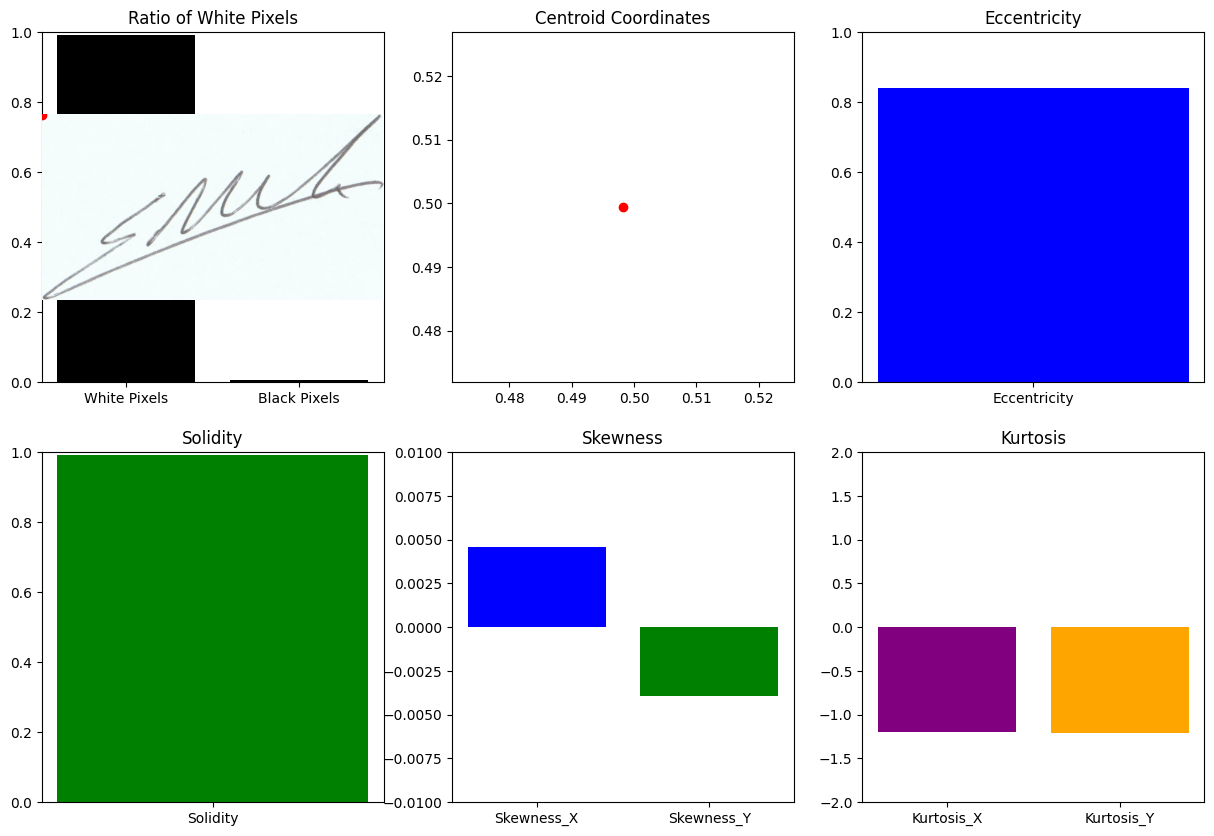

In [13]:
import os
import matplotlib.pyplot as plt
from skimage import io, color
import numpy as np
from skimage.measure import regionprops

def plot_centroid(ax, centroid):
    ax.plot(centroid[1], centroid[0], 'ro', label='Centroid')

def plot_skewness(ax, skewness):
    ax.bar(['Skewness_X', 'Skewness_Y'], skewness, color=['blue', 'green'])
    ax.set_ylim([-0.01, 0.01])

def plot_kurtosis(ax, kurtosis):
    ax.bar(['Kurtosis_X', 'Kurtosis_Y'], kurtosis, color=['purple', 'orange'])
    ax.set_ylim([-2, 2])

def visualize_features(image_path):
    img = io.imread(image_path)
    binary_img = (color.rgb2gray(img) > 0.5).astype(np.uint8)  # Convert to binary

    total_pixels = binary_img.size
    white_pixels = np.sum(binary_img == 1)
    black_pixels = np.sum(binary_img == 0)

    ratio = white_pixels / total_pixels
    centroid = Centroid(binary_img)
    eccentricity, solidity = EccentricitySolidity(binary_img)
    skewness, kurtosis = SkewKurtosis(binary_img)

    print(f"Total Pixels: {total_pixels}")
    print(f"White Pixels: {white_pixels}")
    print(f"Black Pixels: {black_pixels}")

    fig, axs = plt.subplots(2, 3, figsize=(15, 10))

    # Plot Ratio
    axs[0, 0].bar(['White Pixels', 'Black Pixels'], [ratio, 1 - ratio], color=['black', 'black'])
    axs[0, 0].set_ylim([0, 1])
    axs[0, 0].set_title('Ratio of White Pixels')

    # Plot Centroid
    plot_centroid(axs[0, 1], centroid)
    axs[0, 1].set_title('Centroid Coordinates')

    # Plot Eccentricity
    axs[0, 2].bar(['Eccentricity'], [eccentricity], color=['blue'])
    axs[0, 2].set_ylim([0, 1])
    axs[0, 2].set_title('Eccentricity')

    # Plot Solidity
    axs[1, 0].bar(['Solidity'], [solidity], color=['green'])
    axs[1, 0].set_ylim([0, 1])
    axs[1, 0].set_title('Solidity')

    # Plot Skewness
    plot_skewness(axs[1, 1], skewness)
    axs[1, 1].set_title('Skewness')

    # Plot Kurtosis
    plot_kurtosis(axs[1, 2], kurtosis)
    axs[1, 2].set_title('Kurtosis')

    # Overlay features on the image
    ax_img = axs[0, 0].inset_axes([0, 0, 1, 1], transform=axs[0, 0].transAxes)
    ax_img.imshow(img)
    ax_img.axis('off')

    # Overlay Centroid
    plot_centroid(ax_img, centroid)

    plt.show()

# Example image path
image_path = "/content/drive/MyDrive/signature-verification-dataset/sign_data/train/018/01_018.png"

# Visualize features
visualize_features(image_path)


In [14]:
def initialize_base_network(input_shape):
    clf = Sequential()
    clf.add(Convolution2D(64, (3,3),input_shape=input_shape))
    clf.add(Activation('relu'))
    clf.add(MaxPooling2D(pool_size=(2, 2)))
    clf.add(Convolution2D(32, (3,3)))
    clf.add(Activation('relu'))
    clf.add(MaxPooling2D(pool_size=(2, 2)))
    clf.add(Flatten())
    clf.add(Dense(128, activation='relu'))
    clf.add(Dense(64, activation='relu'))
    return clf
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [15]:
input_dim = (100, 100, 1)
base_network = initialize_base_network(input_dim)
img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)
vec_a = base_network(img_a)
vec_b = base_network(img_b)
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([vec_a, vec_b])
prediction = Dense(2, activation='softmax')(distance)
model = Model([img_a, img_b], prediction)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 100, 100, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 64)           2194272     ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

In [16]:
# import tensorflow as tf
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.optimizers.schedules import ExponentialDecay
# from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Dense
# from tensorflow.keras.models import Model

# # Choose the desired base model
# base_model = tf.keras.applications.nasnet.NASNetMobile(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# # Build the model
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = BatchNormalization()(x)
# predictions = Dense(4, activation="softmax")(x)
# model = Model(inputs=base_model.input, outputs=predictions)
# # Define the learning rate schedule
# initial_learning_rate = 0.0001
# lr_schedule = ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=40,
#     decay_rate=0.96,
#     staircase=False
# )

# # Compile the model with the Adam optimizer and the learning rate schedule
# model = Model(inputs=base_model.input, outputs=predictions)
# model.compile(
#     loss='categorical_crossentropy',
#     optimizer=Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
#     metrics=['accuracy']
# )


In [17]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Define the paths to your training and validation datasets
# train_data_dir = '/content/drive/MyDrive/signature-verification-dataset/sign_data/train'
# valid_data_dir = '/content/drive/MyDrive/signature-verification-dataset/sign_data/test'

# # Create ImageDataGenerators
# train_datagen = ImageDataGenerator(rescale=1./255)
# valid_datagen = ImageDataGenerator(rescale=1./255)

# # Flow training images in batches using train_datagen
# train_gen = train_datagen.flow_from_directory(
#     train_data_dir,
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='categorical'  # or other appropriate class_mode
# )

# # Flow validation images in batches using valid_datagen
# valid_gen = valid_datagen.flow_from_directory(
#     valid_data_dir,
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='categorical'  # or other appropriate class_mode
# )


# history = model.fit(x=train_gen, epochs=30, validation_data=valid_gen, steps_per_epoch=None, workers=2)


In [18]:
adam = tf.keras.optimizers.Adam(lr=0.00008)
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])
model.fit([train_images1,train_images2],train_labels,validation_split=.30,batch_size=32,epochs=30)

Epoch 1/30
510/510 [==============================] - 808s 2s/step - loss: 0.6755 - accuracy: 0.5619 - val_loss: 0.7017 - val_accuracy: 0.4854
Epoch 2/30
510/510 [==============================] - 824s 2s/step - loss: 0.6497 - accuracy: 0.5908 - val_loss: 0.7127 - val_accuracy: 0.4665
Epoch 3/30
510/510 [==============================] - 845s 2s/step - loss: 0.6282 - accuracy: 0.6346 - val_loss: 0.7139 - val_accuracy: 0.4715
Epoch 4/30
510/510 [==============================] - 802s 2s/step - loss: 0.6097 - accuracy: 0.6552 - val_loss: 0.7259 - val_accuracy: 0.4609
Epoch 5/30
510/510 [==============================] - 806s 2s/step - loss: 0.6051 - accuracy: 0.6627 - val_loss: 0.7315 - val_accuracy: 0.4844
Epoch 6/30
510/510 [==============================] - 845s 2s/step - loss: 0.5784 - accuracy: 0.6839 - val_loss: 0.7461 - val_accuracy: 0.4761
Epoch 7/30
510/510 [==============================] - 828s 2s/step - loss: 0.5569 - accuracy: 0.7112 - val_loss: 0.7703 - val_accuracy: 0.4689

In [22]:
import tensorflow as tf

try:
    test_images1 = tf.transpose(test_images1, perm=[0, 2, 3, 1])
    test_images2 = tf.transpose(test_images2, perm=[0, 2, 3, 1])
except tf.errors.InvalidArgumentError:
    print("Error: Unable to transpose dimensions. Check the shape of your input data.")

adam = tf.keras.optimizers.Adam(learning_rate=0.00008)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

model.fit([test_images1, test_images2], test_labels, validation_split=0.30, batch_size=32, epochs=25)


Epoch 1/25
128/128 [==============================] - 209s 2s/step - loss: 0.3052 - accuracy: 0.9347 - val_loss: 1.7582 - val_accuracy: 0.4677
Epoch 2/25
128/128 [==============================] - 191s 1s/step - loss: 0.2703 - accuracy: 0.9418 - val_loss: 1.7909 - val_accuracy: 0.4688
Epoch 3/25
128/128 [==============================] - 192s 1s/step - loss: 0.2453 - accuracy: 0.9472 - val_loss: 1.8188 - val_accuracy: 0.4619
Epoch 4/25
128/128 [==============================] - 197s 2s/step - loss: 0.2275 - accuracy: 0.9538 - val_loss: 1.8154 - val_accuracy: 0.4579
Epoch 5/25
128/128 [==============================] - 193s 2s/step - loss: 0.2149 - accuracy: 0.9617 - val_loss: 1.8361 - val_accuracy: 0.4556
Epoch 6/25
128/128 [==============================] - 194s 2s/step - loss: 0.2061 - accuracy: 0.9656 - val_loss: 1.8391 - val_accuracy: 0.4539
Epoch 7/25
128/128 [==============================] - 195s 2s/step - loss: 0.1987 - accuracy: 0.9698 - val_loss: 1.8480 - val_accuracy: 0.4516

In [23]:
!pip install seaborn

In [24]:
!pip install scikit-plot

728/728 [==============================] - 256s 351ms/step
Training Precision: 0.842
Training Recall: 0.833
182/182 [==============================] - 57s 313ms/step
Test Precision: 0.851
Test Recall: 0.830


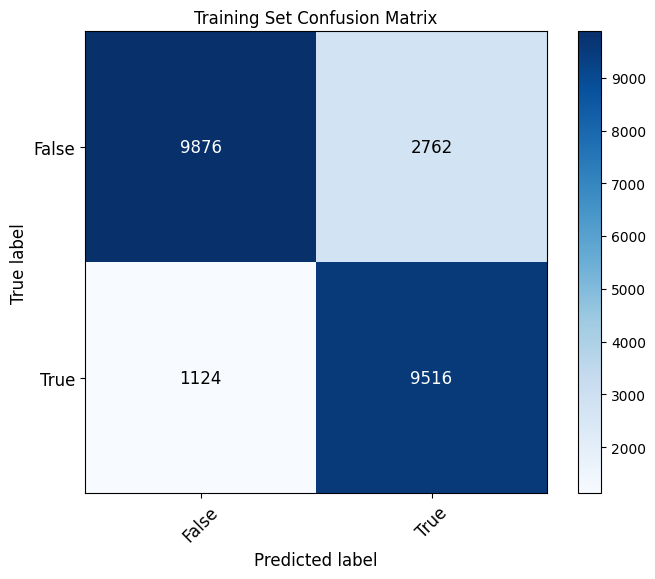

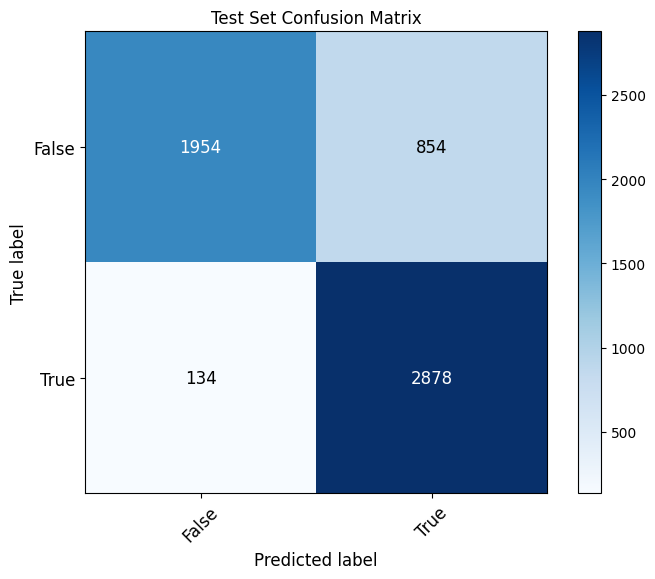

In [25]:
import scikitplot as skplt
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt

# Assuming 'model' is your loaded model
predictions = model.predict([train_images1, train_images2])

# Threshold for classifying predictions
threshold = 0.5
predicted_labels = (predictions > threshold).astype(int)

true_labels_onehot = train_labels
predicted_labels_onehot = (predictions > threshold).astype(int)

# Convert one-hot encoded labels to binary
y_train_binary = (true_labels_onehot.argmax(axis=1) == 1)
y_pred_train_binary = (predicted_labels_onehot.argmax(axis=1) == 1)

# Calculate precision and recall for the training set
precision_train = precision_score(y_train_binary, y_pred_train_binary, average='weighted')
recall_train = recall_score(y_train_binary, y_pred_train_binary, average='weighted')

print(f'Training Precision: {precision_train:.3f}')
print(f'Training Recall: {recall_train:.3f}')

# Plot confusion matrix for the training set
skplt.metrics.plot_confusion_matrix(
    y_train_binary,
    y_pred_train_binary,
    figsize=(8, 6),
    title='Training Set Confusion Matrix',
    text_fontsize='12',
    cmap='Blues',
    x_tick_rotation=45
)

# Assuming 'test_images1' and 'test_images2' are your test images
test_predictions = model.predict([test_images1, test_images2])

# Threshold for classifying test predictions
test_threshold = 0.5
test_predicted_labels = (test_predictions > test_threshold).astype(int)

true_test_labels_onehot = test_labels
predicted_test_labels_onehot = (test_predictions > test_threshold).astype(int)

# Convert one-hot encoded labels to binary for scikitplot
y_test_binary = (true_test_labels_onehot.argmax(axis=1) == 1)
y_pred_test_binary = (predicted_test_labels_onehot.argmax(axis=1) == 1)

# Calculate precision and recall for the test set
precision_test = precision_score(y_test_binary, y_pred_test_binary, average='weighted')
recall_test = recall_score(y_test_binary, y_pred_test_binary, average='weighted')

print(f'Test Precision: {precision_test:.3f}')
print(f'Test Recall: {recall_test:.3f}')

# Plot confusion matrix for the test set
skplt.metrics.plot_confusion_matrix(
    y_test_binary,
    y_pred_test_binary,
    figsize=(8, 6),
    title='Test Set Confusion Matrix',
    text_fontsize='12',
    cmap='Blues',
    x_tick_rotation=45
)

plt.show()


182/182 [==============================] - 58s 317ms/step


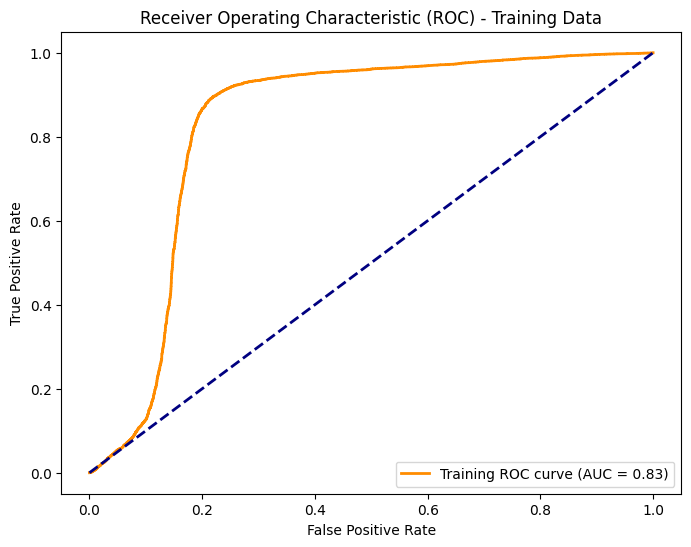

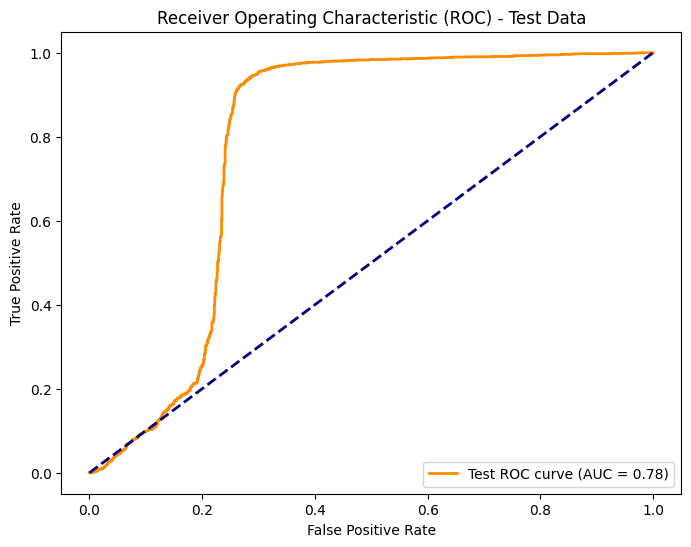

In [26]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

predictions_train = model.predict([train_images1, train_images2])
predictions_test = model.predict([test_images1, test_images2])

y_train_binary = (train_labels.argmax(axis=1) == 1)
y_test_binary = (test_labels.argmax(axis=1) == 1)

fpr_train, tpr_train, thresholds_train = roc_curve(y_train_binary, predictions_train[:, 1])

fpr_test, tpr_test, thresholds_test = roc_curve(y_test_binary, predictions_test[:, 1])

roc_auc_train = auc(fpr_train, tpr_train)

roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC Curve for training data
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'Training ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Training Data')
plt.legend(loc='lower right')
plt.show()

# Plot ROC Curve for test data
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Test Data')
plt.legend(loc='lower right')
plt.show()


In [30]:
from tensorflow.keras.preprocessing import image
import tensorflow as tf
import numpy as np

# Prompt the user for input
img_path = input("Enter the path of the image: ")

# Load and preprocess the image
img = image.load_img(img_path, target_size=(100, 100))
img = image.img_to_array(img)
img = tf.image.rgb_to_grayscale(img)
img = np.expand_dims(img, axis=0)
img = img / 255.0

# Assuming 'model' is your loaded model
input_layer1 = model.layers[0].input
input_layer2 = model.layers[1].input

# Apply data augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generate augmented images
augmented_img = datagen.flow(img, batch_size=1)

# Assuming model takes two input images
predictions = model.predict([img, augmented_img[0]], steps=1)

print("Predictions:", predictions)

# Assuming your model predicts binary values (real or fake)
predicted_class = np.argmax(predictions)
print("Predicted Class:", predicted_class)


Enter the path of the image: /content/drive/MyDrive/signature-verification-dataset/sign_data/test/049/10_049.png
1/1 [==============================] - 0s 32ms/step
Predictions: [[0.68820226 0.31179777]]
Predicted Class: 0


In [31]:
# Output the result
if predicted_class == 0:
    print("The image is predicted to be REAL.")
else:
    print("The image is predicted to be FAKE.")

The image is predicted to be REAL.
